In [1]:
# !lscpu
!nvidia-smi

Fri Sep 25 14:39:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q --upgrade pip
!pip install -q tensorflow
!pip install -q shap
# !pip install git+https://github.com/autonomio/talos@1.0
# !python3 -c 'import tensorflow as tf; print(tf.__version__)'

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 319 kB 2.8 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# df = pd.read_csv('/content/drive/My Drive/LNCC/MachineLearning/dataframes/NDS/Completo.csv')
df = pd.read_csv('/content/drive/My Drive/LNCC/MachineLearning/dataframes/NDS/dataset_NAS_OMP_Turing.csv')
# df = pd.read_csv('/content/drive/My Drive/LNCC/MachineLearning/dataframes/NDS/dataset_NAS_OMP_Beholder.csv')
# df = pd.read_csv('/content/drive/My Drive/LNCC/MachineLearning/dataframes/power/dataset_NAS_OMP_Beholder.csv')

df = df[df.workload != 'D']

# Perf only
# df = df[['instructions', 'cycles', 'cpu_migrations', 'branches', 'branch_misses', 'context_switches', 'cache_references', 'cache_misses', 'L1_dcache_stores', 'L1_dcache_loads', 'L1_dcache_load_misses', 'LLC_stores', 'LLC_store_misses', 'LLC_loads', 'thread', 'seconds', 'workload', 'app']]

# Perf with metrics
df = df[['instructions','cycles','cpu_migrations','branches','branch_misses','context_switches','cache_references','cache_misses','L1_dcache_stores','L1_dcache_loads','L1_dcache_load_misses','LLC_stores','LLC_store_misses','LLC_loads','thread','seconds','workload','app','Instructions_per_cycle','Loads_PTI','Stores_PTI','L1_load_ratio','L1_load_rate_PTI','branch_miss_predict_ratio','branch_miss_predict_rate_PTI','cache_misses_PTI']]
# df = df[['instructions','cycles','cpu_migrations','branches','branch_misses','context_switches','cache_references','cache_misses','L1_dcache_stores','L1_dcache_loads','L1_dcache_load_misses','LLC_stores','LLC_loads','thread','seconds','workload','app','MIPS','instructions_per_cycle','Loads_PTI','Stores_PTI','L1_load_ratio','L1_load_rate_PTI','branch_miss_predict_ratio','branch_miss_predict_rate_PTI','cache_misses_PTI']]


del df['thread']
del df['app']
# del df['class']
del df['workload']
# del df['dwarfs']
# del df['energy']
# del df['seconds']

# encoder = LabelEncoder()
# df['app'] = encoder.fit_transform(df['app'])
# df['workload'] = encoder.fit_transform(df['workload'])

# df['app'] = df['app']+1
# df['workload'] = df['workload']+1
 
df = df.replace("nnn",np.nan)
df = df.dropna()
# df = df.apply(pd.to_numeric,errors='coerce')

print(df.shape)
# print(df.columns) 
print(df.dtypes)

(7305, 23)
instructions                      int64
cycles                            int64
cpu_migrations                    int64
branches                          int64
branch_misses                     int64
context_switches                  int64
cache_references                  int64
cache_misses                      int64
L1_dcache_stores                  int64
L1_dcache_loads                   int64
L1_dcache_load_misses             int64
LLC_stores                        int64
LLC_store_misses                  int64
LLC_loads                         int64
seconds                         float64
Instructions_per_cycle          float64
Loads_PTI                       float64
Stores_PTI                      float64
L1_load_ratio                   float64
L1_load_rate_PTI                float64
branch_miss_predict_ratio       float64
branch_miss_predict_rate_PTI    float64
cache_misses_PTI                float64
dtype: object


In [ ]:
df['power'].describe()

count    7440.000000
mean      340.120161
std        49.901843
min       260.000000
25%       302.000000
50%       350.000000
75%       376.000000
max       424.000000
Name: power, dtype: float64

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math

total_items = len(df.columns)
items_per_row = 4
total_rows = math.ceil(total_items / items_per_row)
fig = make_subplots(rows=total_rows, cols=items_per_row)
cur_row = 1
cur_col = 1
for index, column in enumerate(df.columns):
    fig.add_trace(go.Box(y=df[column], name=column), row=cur_row, col=cur_col)
    
    if cur_col % items_per_row == 0:
        cur_col = 1
        cur_row = cur_row + 1
    else:
        cur_col = cur_col + 1
    fig.update_layout(height=600, width=650,  showlegend=False, margin=dict(l=20, r=20, t=20, b=20))
fig.show() 

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math
import numpy as np

total_items = len(df.columns)
items_per_row = 4
total_rows = math.ceil(total_items / items_per_row)

fig = make_subplots(rows=total_rows, cols=items_per_row, subplot_titles=df.columns)

cur_row = 1
cur_col = 1

for index, column in enumerate(df.columns):
    fig.add_trace(go.Scattergl(x=df[column], 
                            y=df['seconds'], 
                            mode="markers", 
                            marker=dict(size=3)), 
                  row=cur_row, 
                  col=cur_col)
    
    intercept = np.poly1d(np.polyfit(df[column], df['seconds'], 1))(np.unique(df[column]))
    
    fig.add_trace(go.Scatter(x=np.unique(df[column]), 
                             y=intercept, 
                             line=dict(color='red', width=1)), 
                  row=cur_row, 
                  col=cur_col)
    
    if cur_col % items_per_row == 0:
        cur_col = 1
        cur_row = cur_row + 1
    else:
        cur_col = cur_col + 1
    fig.update_layout(height=800, width=900, showlegend=False, margin=dict(l=20, r=20, t=20, b=20))
fig.show()

In [ ]:
corr.shape

(24, 24)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



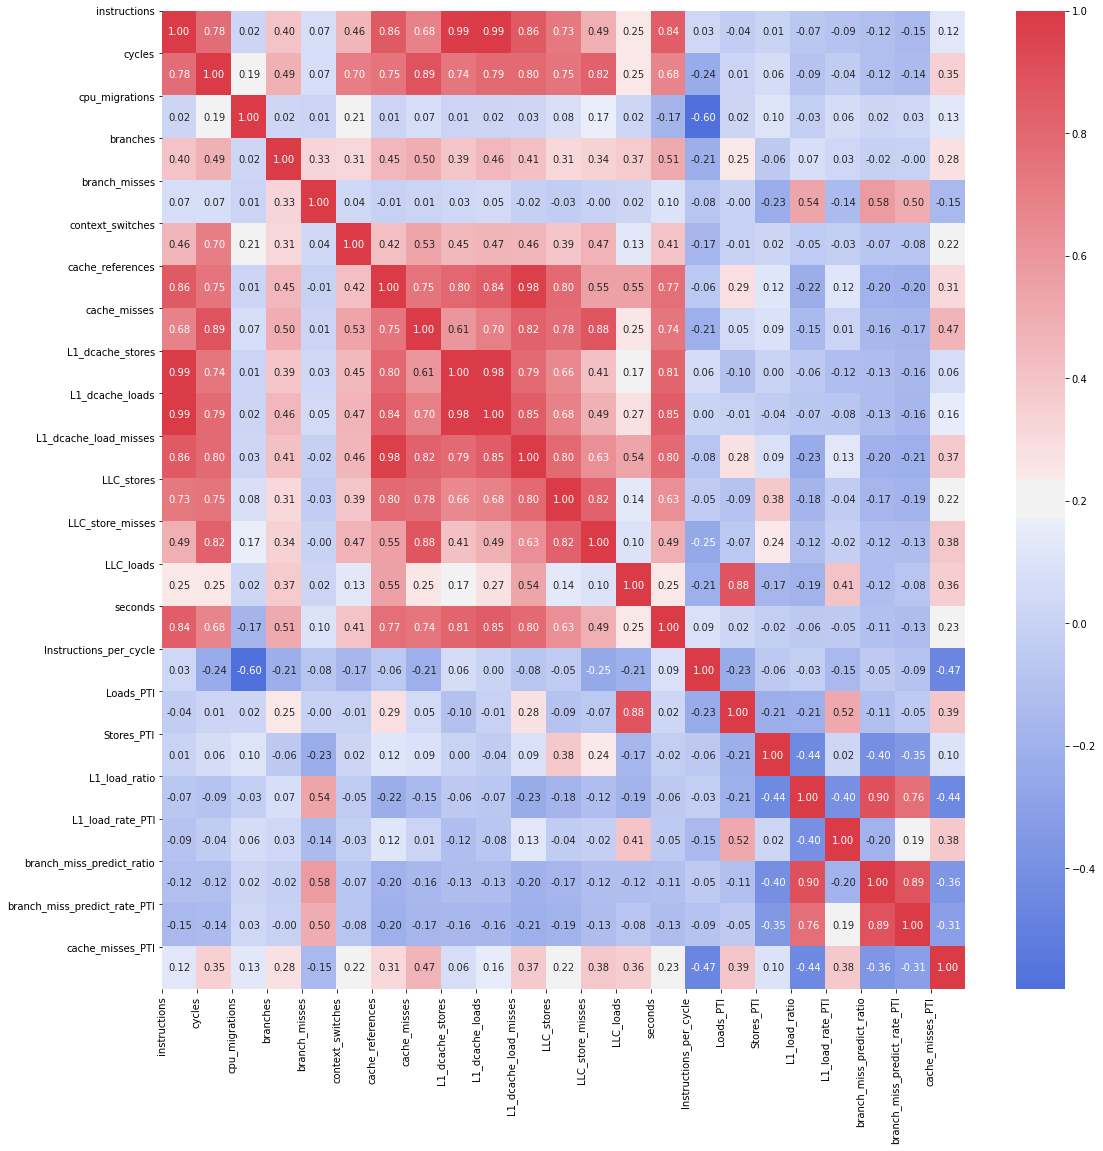

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.corr()
fig, ax = plt.subplots(figsize=(18, 18))

colormap = sns.diverging_palette(260, 10, as_cmap=True)

sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")

plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)

# timestr = time.strftime("%Y%m%d_%Hh%Mm%Ss")
plt.show()

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split

# seconds = pd.DataFrame(df['seconds'])
# energy = pd.DataFrame(df['energy'])

# X = df.drop(['power', 'seconds', 'energy'], axis=1)
X = df.drop(['seconds'], axis=1)
y = df['seconds']
 
scaler = MinMaxScaler()
scaler.fit(X)
X_scale = scaler.transform(X)
 
selector = SelectKBest(f_regression, k='all')
selector.fit(X_scale, y)
X_new = selector.transform(X_scale)
features = list(X.columns[selector.get_support(indices=True)])
 
X_final = pd.DataFrame(data=X_new, columns=X.columns)
 
X_train, X_test, y_train, y_test = train_test_split(X_final, y, train_size=0.8, test_size=0.2, random_state=0)
# X_train_seconds, X_test_seconds, y_train_seconds, y_test_seconds = train_test_split(seconds, y, test_size=0.2, random_state=0)
# X_train_energy, X_test_energy, y_train_energy, y_test_energy = train_test_split(energy, y, test_size=0.2, random_state=0)
 

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)


print("X_train.shape =", X_train.shape, 
      "\nX_test.shape =", X_test.shape,
      "\ny_train.shape =",y_train.shape,
      "\ny_test.shape =", y_test.shape)
 
n_features = X.shape[1]
hidden_neurons = round((n_features/3)*2 + 1)
hidden_neurons2 = round((hidden_neurons/3)*2 + 1)
hidden_neurons3 = round((hidden_neurons2/3)*2 + 1)
 
print('\nn_features:', n_features, '\nhidden_neurons:', hidden_neurons, hidden_neurons2, hidden_neurons3)

X_train.shape = (5844, 22) 
X_test.shape = (1461, 22) 
y_train.shape = (5844,) 
y_test.shape = (1461,)

n_features: 22 
hidden_neurons: 16 12 9


In [7]:
from sklearn.model_selection import KFold, cross_val_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

seed = 7
mse_cvscores = []
mae_cvscores = []
rmse_cvscores = []
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

with tf.device('/gpu:0'):
  for train, test in kfold.split(X_final, y):
    model = Sequential()
    model.add(Dense(n_features, input_shape=(n_features, ), name='dense_1'))
    model.add(Dense(hidden_neurons, activation='relu', name='dense_2'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear', name='dense_output'))

    model.compile(optimizer='adam', loss='mse', metrics=['mae', rmse])

    es = EarlyStopping(monitor='loss', patience=25)

    model.fit(X_final.iloc[train], y.iloc[train], epochs=1000, batch_size=50, verbose=0, callbacks=[es])
    scores = model.evaluate(X_final.iloc[test], y.iloc[test])

    mse_cvscores.append(scores[0])
    mae_cvscores.append(scores[1])
    rmse_cvscores.append(scores[2])

print("MSE: %.2f (+/- %.2f)" % (np.mean(mse_cvscores), np.std(mse_cvscores)))
print("MAE: %.2f (+/- %.2f)" % (np.mean(mae_cvscores), np.std(mae_cvscores)))
print("RMSE: %.2f (+/- %.2f)" % (np.mean(rmse_cvscores), np.std(rmse_cvscores)))

NameError: ignored

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend

def rmse(y_true, y_pred):
  return backend.sqrt(backend.mean(backend.square(y_pred - y_true)))
 
model = Sequential()

# mirrored_strategy = tf.distribute.MirroredStrategy()

# lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.3)

model.add(Dense(n_features, input_shape=(n_features, ), name='dense_1'))
# with mirrored_strategy.scope():
model.add(Dense(hidden_neurons, activation='relu', name='dense_2'))
model.add(Dropout(0.1))
# model.add(Dense(hidden_neurons2, activation='relu', name='dense_3'))
# model.add(Dropout(0.1))
# model.add(Dense(hidden_neurons3, activation='relu', name='dense_4'))
# model.add(Dropout(0.1))
model.add(Dense(1, activation='linear', name='dense_output'))
 
model.compile(optimizer='adam', loss='mse', metrics=['mae', rmse])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 22)                506       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                368       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_output (Dense)         (None, 1)                 17        
Total params: 891
Trainable params: 891
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=25)
checkpoint = ModelCheckpoint("/content/drive/My Drive/LNCC/MachineLearning/weights/model.hdf5", monitor='val_loss', verbose=2, save_best_only=True, mode='auto')
 
with tf.device('/gpu:0'):
  history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), batch_size=50, verbose=2, callbacks=[es, checkpoint])

Epoch 1/1000

Epoch 00001: val_loss improved from inf to 6277.13330, saving model to /content/drive/My Drive/LNCC/MachineLearning/weights/model.hdf5
117/117 - 1s - loss: 8037.7310 - mae: 39.9585 - rmse: 85.7139 - val_loss: 6277.1333 - val_mae: 34.9835 - val_rmse: 75.8222
Epoch 2/1000

Epoch 00002: val_loss improved from 6277.13330 to 3406.68213, saving model to /content/drive/My Drive/LNCC/MachineLearning/weights/model.hdf5
117/117 - 0s - loss: 5561.9458 - mae: 36.4453 - rmse: 70.5944 - val_loss: 3406.6821 - val_mae: 35.5348 - val_rmse: 55.4380
Epoch 3/1000

Epoch 00003: val_loss improved from 3406.68213 to 2015.29614, saving model to /content/drive/My Drive/LNCC/MachineLearning/weights/model.hdf5
117/117 - 0s - loss: 3211.2307 - mae: 34.1885 - rmse: 53.5431 - val_loss: 2015.2961 - val_mae: 26.7734 - val_rmse: 42.0821
Epoch 4/1000

Epoch 00004: val_loss improved from 2015.29614 to 1402.85229, saving model to /content/drive/My Drive/LNCC/MachineLearning/weights/model.hdf5
117/117 - 0s -

In [16]:
import plotly.graph_objects as go
 
fig = go.Figure()
 
fig.add_trace(go.Scattergl(y=history.history['loss'],
                    name='Train'))
 
fig.add_trace(go.Scattergl(y=history.history['val_loss'],
                    name='Valid'))
 
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='Mean Squared Error',
                  margin=dict(l=20, r=20, t=20, b=20))
 
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scattergl(y=history.history['mae'],
                    name='Train'))
 
fig.add_trace(go.Scattergl(y=history.history['val_mae'],
                    name='Valid'))
 
fig.update_layout(height=300, width=600,
                  xaxis_title='Epoch',
                  yaxis_title='Mean Absolute Error',
                  margin=dict(l=20, r=20, t=20, b=20))
 
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scattergl(y=history.history['rmse'],
                    name='Train'))
 
fig.add_trace(go.Scattergl(y=history.history['val_rmse'],
                    name='Valid'))
 
fig.update_layout(height=500, width=600,
                  xaxis_title='Epoch',
                  yaxis_title='Root Mean Squared Error',
                  margin=dict(l=20, r=20, t=20, b=20))
 
fig.show()

In [17]:
fig = go.Figure()

fig.add_trace(go.Scattergl(y=history.history['mae'],
                    name='MAE Train'))
 
fig.add_trace(go.Scattergl(y=history.history['val_mae'],
                    name='MAE Valid'))

fig.add_trace(go.Scattergl(y=history.history['rmse'],
                    name='RMSE Train'))
 
fig.add_trace(go.Scattergl(y=history.history['val_rmse'],
                    name='RMSE Valid'))
 
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='Error Progression',
                  margin=dict(l=20, r=20, t=20, b=20))
 
fig.show()

In [18]:
y_pred_nn = model.predict(X_test)
y_pred_nn = y_pred_nn.flatten()
 
mse_nn, mae_nn, rmse_nn = model.evaluate(X_test, y_test)
 
print('NN MSE: {:.3f}'.format(mse_nn))
print('NN MAE: {:.3f}'.format(mae_nn))
print('NN RMSE: {:.3f}'.format(rmse_nn))

46/46 [==============================] - 0s 2ms/step - loss: 101.1558 - mae: 4.5322 - rmse: 8.7155
NN MSE: 101.156
NN MAE: 4.532
NN RMSE: 8.716


In [ ]:
df_pred = pd.DataFrame()

df_pred['y_test'] = y_test
df_pred['y_pred_nn'] = y_pred_nn
df_pred['y_pred_tree'] = y_pred_tree

df_pred.describe()

,y_test,y_pred_nn,y_pred_tree
count,1488.000000,1488.000000,1488.000000
mean,338.965054,333.708221,339.208816
std,50.413103,38.915081,49.885261
min,260.000000,217.373917,262.000000
25%,302.000000,305.614090,303.881988
50%,350.000000,333.271591,342.701847
75%,376.000000,363.966087,372.006780
max,424.000000,431.477661,411.989655


In [ ]:
df_run = pd.read_csv('/content/drive/My Drive/NeuralNet/df_pred_beholder_W-C.csv')
df_run['y_pred_nn']

0       1065.476800
1         11.440329
2          1.073425
3          1.073425
4         86.449770
           ...     
1483       1.073425
1484       7.131754
1485       1.073425
1486       1.593581
1487     133.291850
Name: y_pred_nn, Length: 1488, dtype: float64

In [ ]:
df_run['y_pred_nn'].head()

0    1065.476800
1      11.440329
2       1.073425
3       1.073425
4      86.449770
Name: y_pred_nn, dtype: float64

In [ ]:
df_pred['y_pred_power'].head()

641     336.400208
5697    281.280945
6696    332.685516
1154    257.124786
8029    326.098572
Name: y_pred_power, dtype: float32

In [ ]:
y_test

641     324
5697    262
6696    376
1154    262
8029    334
       ... 
6659    354
4972    402
2279    262
1073    262
2775    320
Name: power, Length: 1488, dtype: int64

In [ ]:
df

In [ ]:
df_pred = pd.DataFrame()

df_pred['y_test'] = y_test.values
df_pred['y_pred_power'] = y_pred_nn
df_pred['y_pred_time'] = df_run['y_pred_nn']
df_pred['y_energy'] = df_pred['y_pred_power'] * df_pred['y_pred_time']

df_pred.sample(10)

,y_test,y_pred_power,y_pred_time,y_energy
1297,424,425.278900,16.532420,7030.889394
631,324,336.560211,1073.040800,361142.838255
1110,302,300.029510,2.318759,695.696128
679,262,270.738861,1.073425,290.617943
851,354,349.313721,1.779519,621.610438
650,424,391.203644,10.761172,4209.809698
276,360,349.807404,254.859270,89151.659513
738,354,348.059845,18.866570,6566.695429
1206,302,282.051544,4.066348,1146.919733
1339,264,291.647858,1.263764,368.574180


In [ ]:
df_pred['time_real'] = X_test_seconds.values
df_pred['real_energy'] = X_test_energy.values
df_pred['energy2'] = df_pred['y_test'] * df_pred['time_real']
df_pred.head(10)

,y_test,y_pred_power,y_pred_time,y_energy,real_energy,time_real,energy2
0,324,336.400208,1065.476800,358426.616627,4921.992216,1108.23,359066.52
1,262,281.280945,11.440329,3217.946550,4553.986009,0.43,112.66
2,376,332.685516,1.073425,357.113050,3581.549982,1.07,402.32
3,262,257.124786,1.073425,276.004251,1054.119940,0.17,44.54
4,334,326.098572,86.449770,28191.146527,7787.919256,96.55,32247.70
5,354,347.473694,422.932560,146957.938872,3244.348779,446.46,158046.84
6,398,412.644409,12.148238,5012.902492,1448.660040,10.61,4222.78
7,262,274.384888,-0.045238,-12.412497,5875.839270,0.27,70.74
8,398,386.898926,28.632090,11077.724864,9506.887455,34.37,13679.26
9,262,269.064697,1.539964,414.349867,1276.126350,0.32,83.84


In [ ]:
df_pred.head()

,y_test,y_pred_nn
6411,2.73,3.224097
7576,209.28,208.379593
8499,31.39,30.812727
456,120.44,112.523666
572,34.64,32.417610


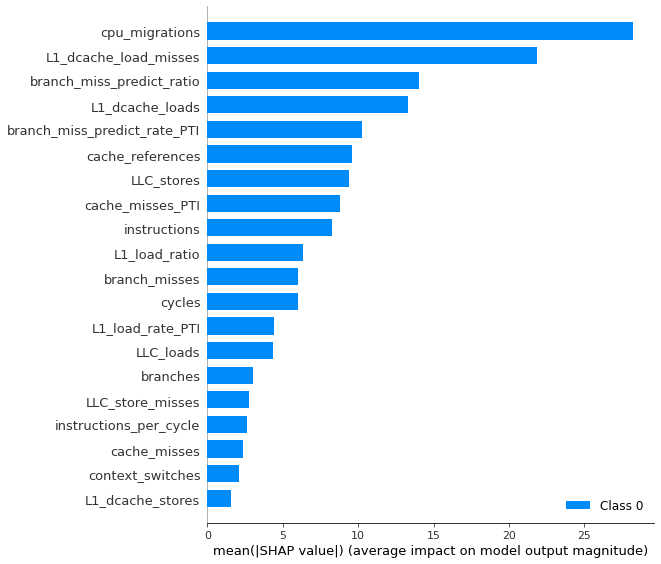

In [ ]:
import shap
shap.initjs()

explainer = shap.DeepExplainer(model, X_train.sample(frac=0.5,random_state=0).values)
shap_values = explainer.shap_values(X_test.sample(frac=0.5,random_state=0).values)
 
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_test, y=y_pred_nn,
                    mode='markers',
                    name='NN pred'))

fig.add_trace(go.Scatter(x=y_test, y=y_test,
                    mode='lines',
                    name='Real values'))

fig.add_trace(go.Scatter(x=y_test, y=y_pred_tree,
                    mode='markers',
                    name='DTR pred'))

# fig.add_trace(go.Scatter(x=y_test, y=y_pred_svr,
#                     mode='markers',
#                     name='SVR pred'))

fig.update_layout(height=500, width=1200, margin=dict(l=20, r=20, t=20, b=20))

fig.show()

DTR MSE: 131.118
DTR MAE: 6.030
DTR RMSE: 11.451
|--- L1_dcache_stores <= 0.31
|   |--- L1_dcache_loads <= 0.07
|   |   |--- L1_dcache_loads <= 0.02
|   |   |   |--- branch_miss_predict_ratio <= 0.00
|   |   |   |   |--- Loads_PTI <= 0.00
|   |   |   |   |   |--- value: [33.71]
|   |   |   |   |--- Loads_PTI >  0.00
|   |   |   |   |   |--- value: [13.44]
|   |   |   |--- branch_miss_predict_ratio >  0.00
|   |   |   |   |--- L1_dcache_loads <= 0.00
|   |   |   |   |   |--- value: [1.27]
|   |   |   |   |--- L1_dcache_loads >  0.00
|   |   |   |   |   |--- value: [5.21]
|   |   |--- L1_dcache_loads >  0.02
|   |   |   |--- cpu_migrations <= 0.13
|   |   |   |   |--- context_switches <= 0.02
|   |   |   |   |   |--- value: [38.33]
|   |   |   |   |--- context_switches >  0.02
|   |   |   |   |   |--- value: [64.71]
|   |   |   |--- cpu_migrations >  0.13
|   |   |   |   |--- cpu_migrations <= 0.21
|   |   |   |   |   |--- value: [30.86]
|   |   |   |   |--- cpu_migrations >  0.21
|   | 

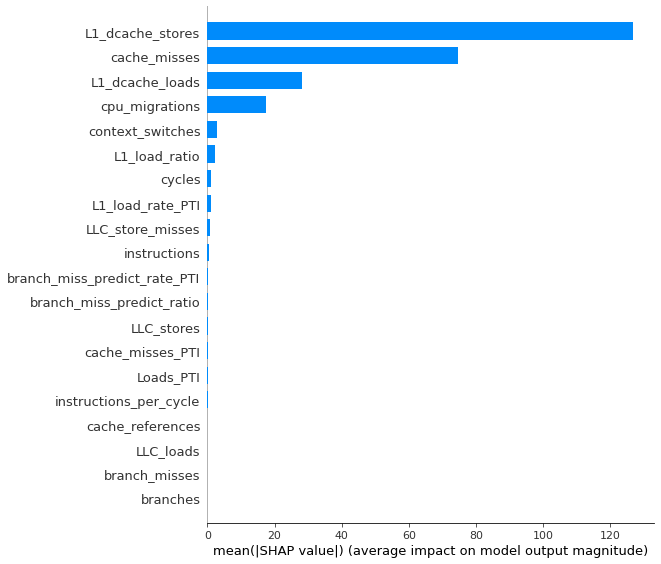

In [ ]:
import shap
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

tree = DecisionTreeRegressor(criterion='mse', max_depth=5)

tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_tree)
mae_dt = mean_absolute_error(y_test, y_pred_tree)
rmse_dt = sqrt(mean_squared_error(y_test, y_pred_tree))

print('DTR MSE: {:.3f}'.format(mse_dt))
print('DTR MAE: {:.3f}'.format(mae_dt))
print('DTR RMSE: {:.3f}'.format(rmse_dt))

# plot_tree(tree, feature_names=X.columns)
r = export_text(tree, feature_names=features)
print(r)

shap.initjs()

explainer = shap.TreeExplainer(tree, X_train.sample(frac=0.5,random_state=0).values)
shap_values = explainer.shap_values(X_test.sample(frac=0.5,random_state=0).values)
 
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [ ]:
df_pred = pd.DataFrame()

df_pred['y_test'] = y_test
df_pred['neural_network'] = y_pred_nn
# df_pred['y_pred_lr'] =y_pred_lr
# df_pred['y_pred_svr'] = y_pred_svr
df_pred['decision_tree'] = y_pred_tree
# df_pred['y_pred_rfr'] = y_pred_rfr


df_pred.describe()

,y_test,neural_network,decision_tree
count,1461.00000,1461.000000,1461.000000
mean,38.95655,38.687397,38.571165
std,76.80887,76.347153,76.020166
min,0.11000,-5.018104,0.451375
25%,0.97000,1.211810,1.305424
50%,7.06000,6.674755,7.000842
75%,33.41000,32.743515,36.327755
max,539.98000,531.345520,539.907000


In [ ]:
df_metrics = pd.DataFrame()

df['MSE'] = 
df['MAE'] = 
df['RMSE'] = 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print('Mean squared error on test data: ', mse_lr)
print('Mean absolute error on test data: ', mae_lr)

Mean squared error on test data:  712.1129851407154
Mean absolute error on test data:  15.22981540896772


In [ ]:
from sklearn.svm import SVR

svr_model = SVR()
svr_model.fit(X_train, y_train)

y_pred_svr = svr_model.predict(X_test)

mse_svr = mean_squared_error(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)

print('Mean squared error on test data: ', mse_svr)
print('Mean absolute error on test data: ', mae_svr)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(criterion='mse', max_depth=5)

rfr.fit(X_train, y_train)

y_pred_rfr = rfr.predict(X_test)

mse_rfr = mean_squared_error(y_test, y_pred_rfr)
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)

print('Mean squared error on test data: ', mse_rfr)
print('Mean absolute error on test data: ', mae_rfr)

<h1>Validação Abaixo</h1>

In [ ]:
from tensorflow.keras.models import load_model
model_val = load_model('/content/drive/My Drive/LNCC/MachineLearning/weights/model.hdf5')

In [ ]:
df2 = pd.read_csv('/content/drive/My Drive/LNCC/MachineLearning/dataframes/data_nas_swabc_sorted.csv')

del df2['cpu-clock']
del df2['App']
del df2['Size']

df2 = df2.replace("nnn", np.nan)
df2 = df2.dropna()
df2 = df2.apply(pd.to_numeric, errors='coerce')

In [ ]:
intersec = list(set(df.columns) & set(df2.columns))
df2 = df2[intersec]
df2.shape

In [ ]:
X_val = df2.drop('runtime', axis=1)
y_val = df2['runtime']

X_val_scal = scaler.transform(X_val)

X_val_new = pd.DataFrame(X_val_scal, columns=X_val.columns)

In [ ]:
print(y_val.mean(), y_val.std())
print(y.mean(), y.std())

In [ ]:
y_val_pred = model_val.predict(X_val_new)
y_val_pred = y_val_pred.flatten()

mse_val, mae_val = model.evaluate(X_val, y_val)

print('Mean squared error on test data: ', mse_val)
print('Mean absolute error on test data: ', mae_val)